In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
from matplotlib.colors import Normalize, ListedColormap, LinearSegmentedColormap

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR


# Figure 3: Population centers of San Diego County
Travel surveys indicate that that majority of visitors from Baja California into San Diego, travel less than 30 miles in the US. We plot the population density of San Diego and the HHSA regions contained within it, to estimate the regions that importations would most likely land in.

We load a dictionary describing the HHSA region that each ZIP code is assigned.

In [2]:
regs = pd.read_csv( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/data/SanDiegoZIP_region.csv" )
regs.head()

,ZIP,Region
0,92101,Central
1,92102,Central
2,92103,Central
3,92104,Central
4,92105,Central


We load the populations of each ZIP code.

In [3]:
pops = pd.read_csv( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/sequencing_dashboard/resources/zip_pop.csv", thousands=",")
pops = pops.drop( columns=["Geography"] )
pops.columns = ["ZIP", "population", "area", "population_per_area"]
pops = pops.merge( regs, on="ZIP", how="left" )
pops.head()

,ZIP,population,area,population_per_area,Region
0,92161,0,0.0,0,North Central
1,92182,606,1.0,606,Central
2,92096,3395,1.0,3395,North Inland
3,92136,10699,1.0,10699,Central
4,89010,31,14.7,2,NaN


We load a shapefile containing the geometries for each ZIP code in San Diego. Seperately, we collapse the ZIP codes for each region to determine the boundaryies of each region.

In [4]:
sd = gpd.read_file( "/Users/natem/Documents/Data/shapefiles/SanDiego_zip/Census_Tracts_and_Zip_Codes_(gissd.sandag.org).shp")
sd = sd[["ZIP", "geometry"]]
sd = sd.merge( pops, on="ZIP", how="left" )
sd["geometry"] = sd["geometry"].buffer( 50 )
regions = sd.dissolve( by="Region" )
sd.head()

/Users/natem/mambaforge/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/natem/mambaforge/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


,ZIP,geometry,population,area,population_per_area,Region
0,91901,"POLYGON ((-13004618.322 3872362.346, -13004619...",17403,89.3,195,East
1,91902,"POLYGON ((-13031558.241 3849252.972, -13031558...",17653,8.7,2028,South
2,91905,"POLYGON ((-12952830.490 3856189.331, -12952894...",1700,65.8,26,East
3,91906,"POLYGON ((-12975919.036 3850780.083, -12975920...",3627,105.5,34,East
4,91910,"POLYGON ((-13036151.564 3849040.452, -13036149...",75802,12.2,6196,South


We also load the shapefile for Baja California, to indicate its relation to each HHSA region.

In [5]:
bc = gpd.read_file( "/Users/natem/Documents/Data/shapefiles/NA_states/bound_p.shp" )
bc = bc.loc[bc["NAME"]=="Baja California"]
bc = bc.to_crs( sd.crs )
bc.head()

,OBJECTID,BOUND_P_,UIDENT,NAME,COUNTRY,STATEABB,Shape_Leng,Shape_Area,geometry
1011,1012,1445.0,142204.0,Baja California,MEX,MX-BCN,17.704388,6.652600,"POLYGON ((-12782080.490 3827615.923, -12782620..."
1017,1018,1451.0,142804.0,Baja California,MEX,MX-BCN,0.410486,0.007575,"POLYGON ((-12774919.986 3736882.547, -12768364..."
1037,1038,1471.0,144804.0,Baja California,MEX,MX-BCN,0.084784,0.000410,"POLYGON ((-12734652.993 3498999.156, -12735179..."
1047,1048,1484.0,146104.0,Baja California,MEX,MX-BCN,1.684054,0.076851,"POLYGON ((-12628322.783 3439520.849, -12626876..."
1057,1058,1497.0,147404.0,Baja California,MEX,MX-BCN,0.386492,0.002676,"MULTIPOLYGON (((-13168765.779 3367131.848, -13..."


To determine an appropriate scale for a chloropleth, we determine the range of populations in San Diego ZIP codes.

In [6]:
vmax = sd.loc[sd["area"]>0,"population"].max()
vmin = sd.loc[sd["area"]>0,"population"].min()

We plot the ZIP codes of San Diego, coloring them by the HHSA region they are assigned, and giving them an opacity equivalent to their population. In post-processing we will add arrows, and a label for Baja California.

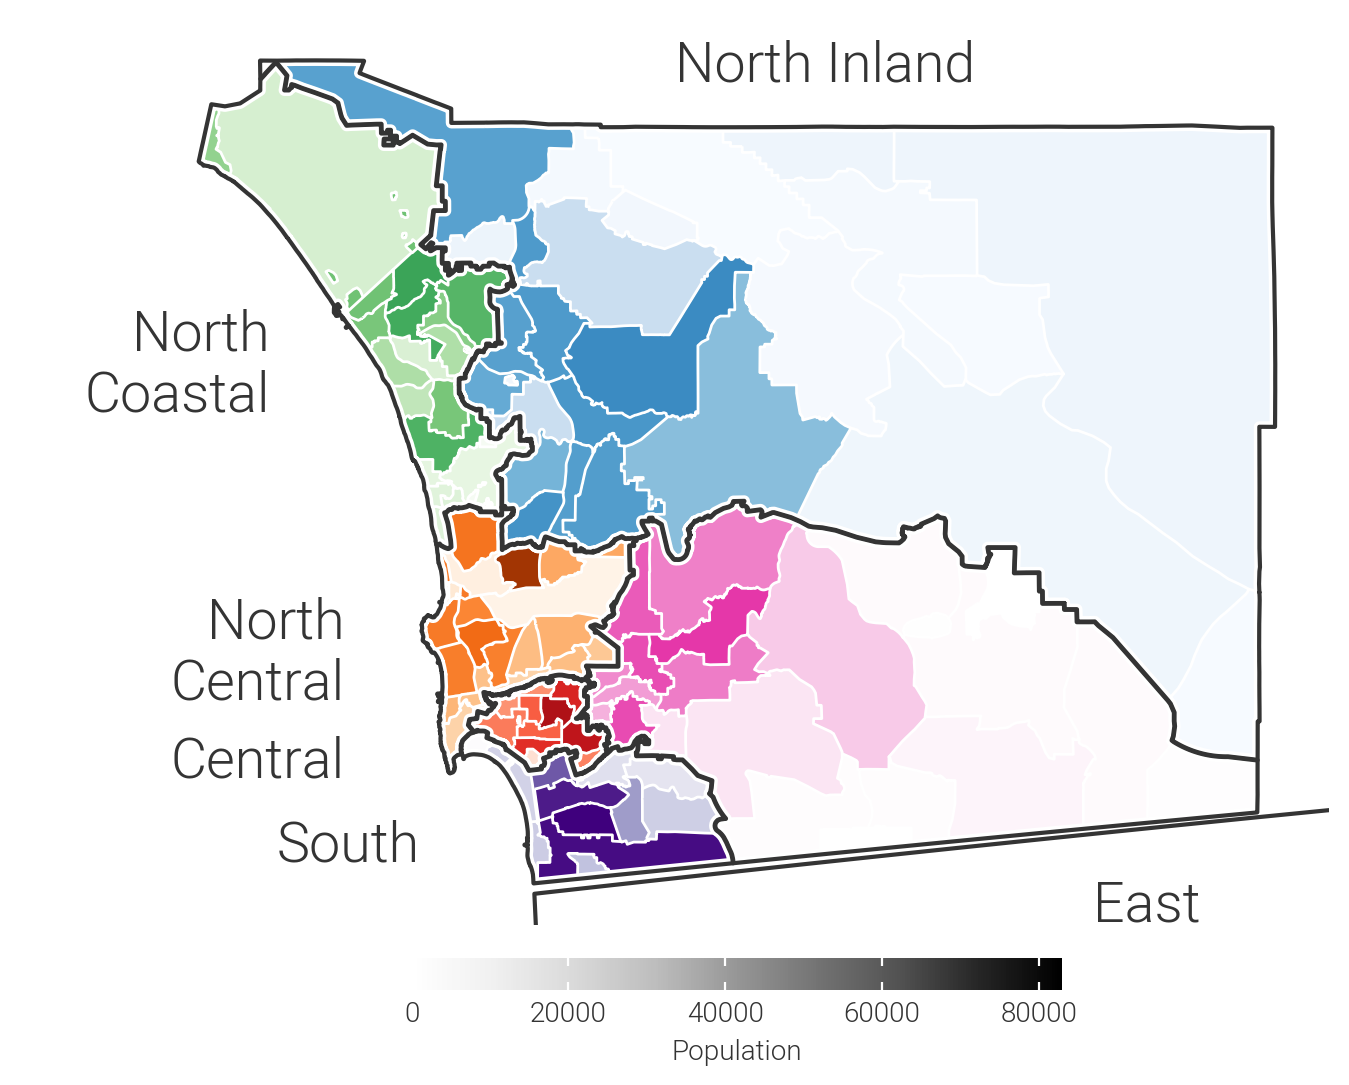

In [7]:
def hex_to_rgb( hex_color: str ) -> tuple:
    hex_color = hex_color.lstrip( "#" )
    if len( hex_color ) == 3:
        hex_color = hex_color * 2
    return int( hex_color[0:2], 16 ), int( hex_color[2:4], 16 ), int( hex_color[4:6], 16 )

def generate_colormap( color, N=256 ):
    hexcolor = hex_to_rgb( color )
    vals = np.ones((N, 4))
    for i in range( 3 ):
        vals[:, i] = hexcolor[i] / 256
    vals[:, 3] = np.linspace( 0, 1, N )
    return ListedColormap( vals )

cmaps = [generate_colormap("#E00093"), "Purples", 'Blues', 'Greens', 'Oranges', 'Reds']
fig, ax = plt.subplots( dpi=200, figsize=(7.5,6) )

for cm, re in zip( cmaps, sd["Region"].unique() ):
    temp = sd.loc[sd["Region"]==re]
    temp.plot( column="population", edgecolor="white", linewidth=1, ax=ax, cmap=cm, vmin=0, vmax=vmax )
#bc.boundary.plot( color="w", linewidth=4, ax=ax )

regions.boundary.plot( color="w", linewidth=4, ax=ax )
regions.boundary.plot( color=COLOR, linewidth=1.5, ax=ax )
bc.scale(1.0, 1.001).boundary.plot( color=COLOR, linewidth=1.5, ax=ax )

arrowprops = dict(arrowstyle="-", relpos=(1,0.5), color=COLOR )
ax.annotate( "North\nCoastal", xy=(.254,.6), xycoords="figure fraction", xytext=(.18,.6), fontsize=20, color=COLOR, ha="right", va="center")
ax.annotate( "North\nCentral", xy=(.5,.5), xycoords="figure fraction", xytext=(.23,.36), fontsize=20, color=COLOR, ha="right", va="center")
ax.annotate( "Central", xy=(.5,.5), xycoords="figure fraction", xytext=(.23,.27), fontsize=20, color=COLOR, ha="right", va="center")
ax.annotate( "South", xy=(.5,.5), xycoords="figure fraction", xytext=(.28,.2), fontsize=20, color=COLOR, ha="right", va="center")
ax.annotate( "North Inland", xy=(.5,.5), xycoords="figure fraction", xytext=(.65,.85), fontsize=20, color=COLOR, ha="right", va="center")
ax.annotate( "East", xy=(.5,.5), xycoords="figure fraction", xytext=(.8,.15), fontsize=20, color=COLOR, ha="right", va="center")

cbar = fig.colorbar( mcm.ScalarMappable( cmap="Greys", norm=Normalize(vmin=0, vmax=vmax ) ), ax=ax, location="bottom", shrink=0.5, pad=0.03 )

cbar.outline.set_visible( False )
cbar.set_label( "Population", fontsize=10 )
cbar.set_ticks( [0, 20000, 40000, 60000, 80000] )
cbar.ax.tick_params( labelsize=10, size=3, bottom=True, top=True, color="w", direction="in", which="both" )

[ax.spines[j].set_visible(False) for j in ax.spines]
ax.set_yticks([])
ax.set_xticks([])

ax.set_xlim(-13099236.849290613, -12913576.69089239)
ax.set_ylim(3827147.4799038116, 3969080.478286)

plt.tight_layout()
plt.savefig( "../analyses/plots/figure3_sd-population-region.pdf", pad_inches=0, bbox_inches="tight" )
plt.show()